# Import the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from numba import jit
import timeit
from interpolation.splines import LinearSpline, CubicSpline
import h5py as h5
from scipy import constants as const
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from scipy.misc import derivative
#%matplotlib inline


#  electrode numbers are:
#   0  -> f1 under (195V)
#   1  -> f4 under (195V)
#   2  -> f1 above (-145V)
#   3  -> f4 above (-232V)
#   4  -> MCP cage (-0.114V)
#   5  -> MCP out (-1900V)
#   6  -> Chamber (0V)
#   7  -> CEM cage (4V)
#   8  -> deflection ring 1 (0.3V)
#   9  -> deflection ring 2 (-232V)
#   10 -> f2 under (195V)
#   11 -> f3 under (195V)
#   12 -> f2 above (-145V)
#   13 -> f3 above (-232V)
#   14-18 -> read out electrodes/cables (0V)

#x_grid = np.array(potential_file["Coordinates/X"].value / 2.)
#y_grid = np.array(potential_file["Coordinates/Y"].value / 2.)
#z_grid = np.array(potential_file["Coordinates/Z"].value / 2.)

C:\Users\REET\miniconda3_new\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [2]:
import xarray as xr
import pandas as pd

In [3]:
def linear(x,a,b):
    return a*x+b

# 1. Get electrode shape and grid

In [7]:
potential_file = h5.File('PA_v4.hdf5', 'r')
coors = [potential_file['Coordinates/' + i][()] / 2. for i in 'XYZ']

coors is a 3 array with inhomogenous lengths  
data points in coors

x $\rightarrow$121

y$\rightarrow$121

z$\rightarrow$173

In [8]:
electrodes = xr.Dataset({
    'electrode' + str(i): 
    xr.DataArray(potential_file['Potential Arrays/electrode' + str(i)][()]/10000, coords=coors, dims=['x', 'y', 'z']) 
    for i in np.arange(1, 19)})
potential_file.close()

In [9]:
print(np.shape(np.array(electrodes.electrode1)))

(121, 121, 173)


# 2. Define Potential Function

In [10]:
def potential(f1_under,f2_under,f3_under,f4_under,
              f1_above,f2_above,f3_above,f4_above,
              MCP_cage,MCP_out,CEM_cage,deflection_ring_1,deflection_ring_2):
    pre_potential = np.array(electrodes.electrode1)*f1_under
    pre_potential += np.array(electrodes.electrode2)*f4_under
    pre_potential += np.array(electrodes.electrode3)*f1_above
    pre_potential += np.array(electrodes.electrode4)*f4_above
    pre_potential += np.array(electrodes.electrode5)*MCP_cage
    pre_potential += np.array(electrodes.electrode6)*MCP_out
    pre_potential += np.array(electrodes.electrode8)*CEM_cage
    pre_potential += np.array(electrodes.electrode9)*deflection_ring_1
    pre_potential += np.array(electrodes.electrode10)*deflection_ring_2
    pre_potential += np.array(electrodes.electrode11)*f2_under
    pre_potential += np.array(electrodes.electrode12)*f3_under
    pre_potential += np.array(electrodes.electrode13)*f2_above
    pre_potential += np.array(electrodes.electrode14)*f3_above
    return pre_potential

# 3. Try out field in z direction

In [11]:
#old_potential = potential(195,195,195,195,-145,-145,-232,-232,-0.114,-1900,4,0.3,-232)

#print(np.shape(old_potential))
new_potential = 40*potential(1,0,1,0,0,-1,0,-1,0,0,0,0,0) #field z


# Find E Field in units of V/cm  
#e_field = -1*np.gradient(new_potential, 0.05) 
# potential was given in discrete steps of 0.5 mm, therefore 0.5mm = 0.05cm, therefore 0.05
# x componenet of E field
e_field_x = -1*np.gradient(new_potential, 0.05, axis=0)
# y componenet of E field
e_field_y = -1*np.gradient(new_potential, 0.05, axis=1)
# z componenet of E field
e_field_z = -1*np.gradient(new_potential, 0.05, axis=2)

# magnitude of electric field
abs_e_field = np.sqrt(e_field_x**2+e_field_y**2+e_field_z**2)

In [12]:
radius_inner=15 #mm
center=[102.5,102.5] # x,y
data_points=100
electrode_coords_inner=np.zeros(shape=(data_points,2))
for i in range(data_points):
    theta=i*np.pi*2/data_points
    electrode_coords_inner[i]= np.cos(theta)*radius_inner +center[0],np.sin(theta)*radius_inner +center[1]
radius_outer=20 #mm
#center=[102.5,102.5] # x,y
electrode_coords_outer=np.zeros(shape=(data_points,2))
for i in range(data_points):
    theta=i*np.pi*2/data_points
    electrode_coords_outer[i]= np.cos(theta)*radius_outer +center[0],np.sin(theta)*radius_outer +center[1]
radius_outer_up=17.5
electrode_coords_outer_up=np.zeros(shape=(data_points,2))
for i in range(data_points):
    theta=i*np.pi*2/data_points
    electrode_coords_outer_up[i]= np.cos(theta)*radius_outer_up +center[0],np.sin(theta)*radius_outer_up +center[1]

In [73]:
#old_potential = potential(195,195,195,195,-145,-145,-232,-232,-0.114,-1900,4,0.3,-232)

#print(np.shape(old_potential))

const_E_in_x = 26.11*potential(1,-1,1,-1,1,-1,1,-1,0,0,0,0,0) #field z
new_potential = const_E_in_x#+40*potential(1,0,1,0,0,-1,0,-1,0,0,0,0,0)

# Find E Field in units of V/cm  
#e_field = -1*np.gradient(new_potential, 0.05) 
# potential was given in discrete steps of 0.5 mm, therefore 0.5mm = 0.05cm, therefore 0.05
# x componenet of E field
e_field_x = -1*np.gradient(new_potential, 0.05, axis=0)
# y componenet of E field
e_field_y = -1*np.gradient(new_potential, 0.05, axis=1)
# z componenet of E field
e_field_z = -1*np.gradient(new_potential, 0.05, axis=2)

# magnitude of electric field
abs_e_field = np.sqrt(e_field_x**2+e_field_y**2+e_field_z**2)
#pot_in_xy_plane=np.zeros()
z_coord=51
#for i_x in range(len(electrodes.x)):
 #   for i_y in range(len(electrodes.y)):
  #      pot_in_xy_plane[i_x][i_y]=new_potential[i_x,i_y,z_coord]
pot_in_xy_plane=new_potential[:,:,z_coord]
skip=4
 #index (in middle of the two elctrode planes)
e_x=e_field_x[::skip,::skip,z_coord]
e_y=e_field_y[::skip,::skip,z_coord]
x=electrodes.x[::skip]
y=electrodes.y[::skip]

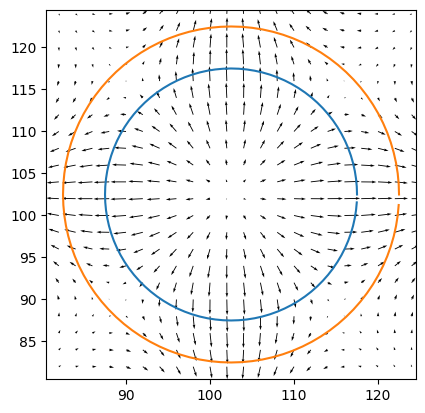

In [74]:

#x,y = np.meshgrid(np.linspace(-5,5,10),np.linspace(-5,5,10))
#plt.xlim(95,115)
#plt.ylim(95,115)
#plt.tight_layout()
plt.plot(electrode_coords_inner[:,0],electrode_coords_inner[:,1])

plt.plot(electrode_coords_outer[:,0],electrode_coords_outer[:,1])

#plt.plot(electrode_coords_outer_up[:,0],electrode_coords_outer_up[:,1])
plt.axis('square')
plt.quiver(x,y,e_x,e_y,scale=None)
plt.show()

In [397]:
np.shape(electrodes.x)

(121,)

In [56]:
const_potentials=np.linspace(5,60,50)
e_along_line_iter=np.zeros(shape=(len(const_potentials),len(electrodes.x)))    
e_perp_line_iter=np.zeros(shape=(len(const_potentials),len(electrodes.x)))    
e_grad_along_line_iter=np.zeros(shape=(len(const_potentials),len(electrodes.x)))
e_grad_perp_line_iter=np.zeros(shape=(len(const_potentials),len(electrodes.x)))

for index in range(len(const_potentials)):
    print(int((index+1)/50*100),'%',end='\r')
    const_E_in_x_iter = const_potentials[index]*potential(1,-1,1,-1,1,-1,1,-1,0,0,0,0,0) #field z
    new_potential_iter = const_E_in_x_iter#+40*potential(1,0,1,0,0,-1,0,-1,0,0,0,0,0)
    e_field_x_iter = -1*np.gradient(new_potential_iter, 0.05, axis=0)
    e_field_y_iter = -1*np.gradient(new_potential_iter, 0.05, axis=1)
    e_field_z_iter = -1*np.gradient(new_potential_iter, 0.05, axis=2)
    #pot_in_xy_plane=np.zeros()
    z_coord_iter=51
    #pot_in_xy_plane_iter=new_potential_iter[:,:,z_coord_iter]
    skip_iter=4
 #index (in middle of the two elctrode planes)
#e_x=e_field_x[::skip,::skip,z_coord]
#e_y=e_field_y[::skip,::skip,z_coord]
#x=electrodes.x[::skip]
#y=electrodes.y[::skip]
    theta_line_with_x_iter = -np.pi/4
    e_field_along_chosen_line_iter=np.cos(theta_line_with_x_iter)*e_field_x_iter + np.sin(theta_line_with_x_iter)*e_field_y_iter 
    e_field_perp_chosen_line_iter=np.cos(np.pi/2+theta_line_with_x_iter)*e_field_x_iter + np.sin(np.pi/2+theta_line_with_x_iter)*e_field_y_iter    
    
    for i in range(len(electrodes.x)):
        e_along_line_iter[index][i]=e_field_along_chosen_line_iter[120-i,i,z_coord_iter]
    
    for i in range(len(electrodes.x)):
        e_perp_line_iter[index][i]=e_field_perp_chosen_line_iter[120-i,i,z_coord_iter]
    #print(np.shape(e_along_line[index][:]))
    e_grad_along_line_iter[index]=np.gradient(e_along_line_iter[index][:],np.sqrt(2)*0.05,axis=0)
    e_grad_perp_line_iter[index]=np.gradient(e_perp_line_iter[index][:],np.sqrt(2)*0.05,axis=0)


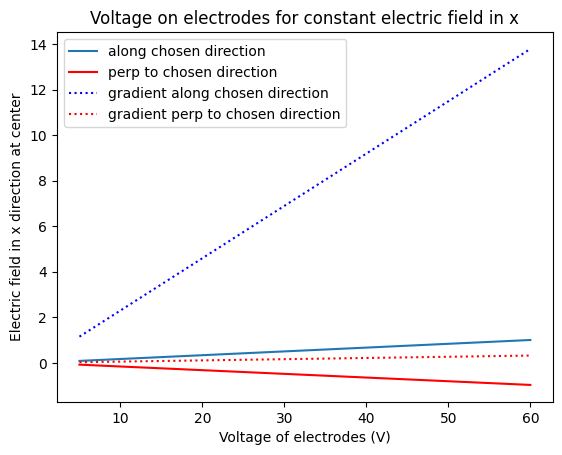

In [57]:
plt.plot(const_potentials,e_along_line_iter[:,61],label='along chosen direction')
plt.plot(const_potentials,e_perp_line_iter[:,61],'r',label='perp to chosen direction')
plt.title("Voltage on electrodes for constant electric field in x")
plt.xlabel("Voltage of electrodes (V)")
plt.ylabel("Electric field in x direction at center")
plt.legend()
#plt.show()

plt.plot(const_potentials,e_grad_along_line_iter[:,61],'b:',label='gradient along chosen direction')
plt.plot(const_potentials,e_grad_perp_line_iter[:,61],'r:',label='gradient perp to chosen direction')
plt.title("Voltage on electrodes for constant electric field in x")
plt.xlabel("Voltage of electrodes (V)")
plt.ylabel("Electric field in x direction at center")
plt.legend()
plt.show()


In [58]:
def line(x,m,c):
    return x*m+c
m_c,variance=curve_fit(line, const_potentials,e_grad_along_line_iter[:,61] )#bounds=(0, [3., 1., 0.5]))

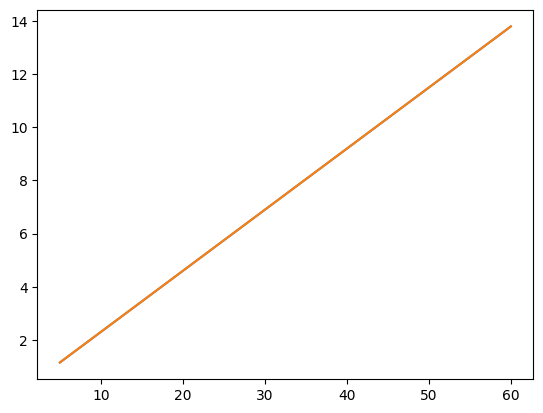

In [60]:
plt.plot(const_potentials,line(const_potentials,m_c[0],m_c[1]))
plt.plot(const_potentials,e_grad_along_line_iter[:,61],label='along chosen direction')

In [72]:
e_field_grad_required=6
potential_required=(e_field_grad_required-m_c[1])/m_c[0]
print(potential_required)

26.110275272312617


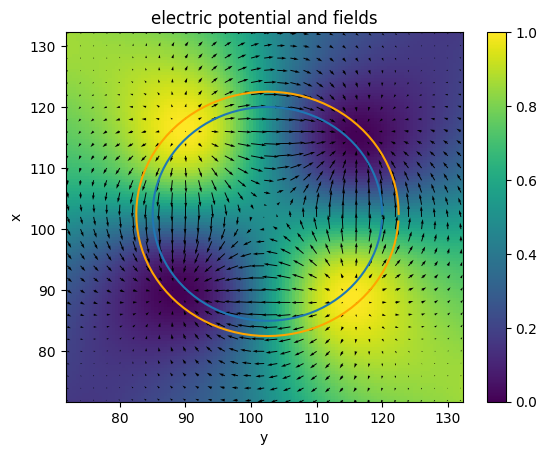

In [75]:

#data = np.random.random((12, 12))
#plt.pcolormesh(pot_in_xy_plane[:,:])#, cmap='viridis')
plt.pcolormesh(electrodes.x,electrodes.y,pot_in_xy_plane)#, cmap='viridis')

#plt.pcolormesh(electrodes.y,electrodes.x,pot_in_xy_plane[:,:])#, cmap='viridis')
plt.title("electric potential and fields")
#plt.plot(electrode_coords[:,0],electrode_coords[:,1],'orange')
plt.quiver(y,x,e_y,e_x,scale=None)
plt.plot(electrode_coords_outer[:,0],electrode_coords_outer[:,1],'orange')

plt.plot(electrode_coords_outer_up[:,0],electrode_coords_outer_up[:,1])
#plt.axvline(x=52)
#plt.axvline(x=51,color='k')
#plt.xlim(5,100)
#plt.axvline(x=31)
#plt.axhline(y=62)
plt.xlabel("y")
plt.ylabel("x")
plt.colorbar()
plt.show()

In [76]:
theta_line_with_x = -np.pi/4
e_field_along_chosen_line=np.cos(theta_line_with_x)*e_field_x + np.sin(theta_line_with_x)*e_field_y 
e_field_perp_chosen_line=np.cos(np.pi/2+theta_line_with_x)*e_field_x + np.sin(np.pi/2+theta_line_with_x)*e_field_y 

In [77]:
e_along_line=np.zeros(shape=(len(electrodes.x),))
for i in range(len(electrodes.x)):
    e_along_line[i]=e_field_along_chosen_line[120-i,i,z_coord]

e_perp_line=np.zeros(shape=(len(electrodes.x),))
for i in range(len(electrodes.x)):
    e_perp_line[i]=e_field_perp_chosen_line[120-i,i,z_coord]


0.00895879965683452


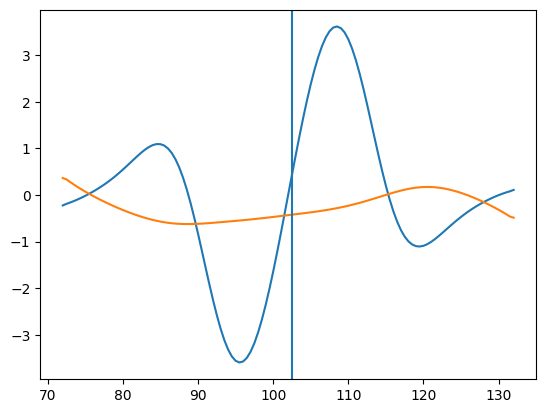

In [86]:
plt.plot(electrodes.x,e_along_line)
plt.plot(electrodes.x,e_perp_line)
print(e_along_line[60])
plt.axvline(x=102.5)

5.999936743825564


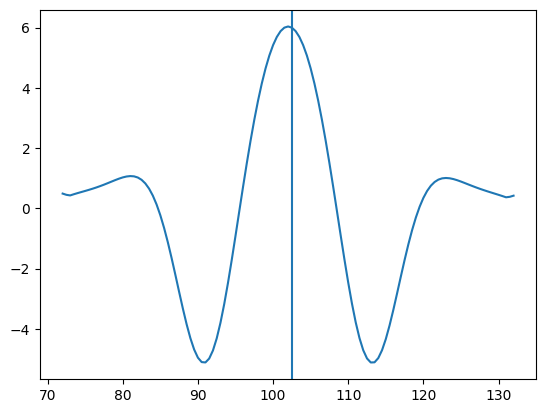

In [79]:
plt.plot(electrodes.x,np.gradient(e_along_line,np.sqrt(2)*0.05))
plt.axvline(x=102.5)
print(np.gradient(e_along_line,np.sqrt(2)*0.05)[61])

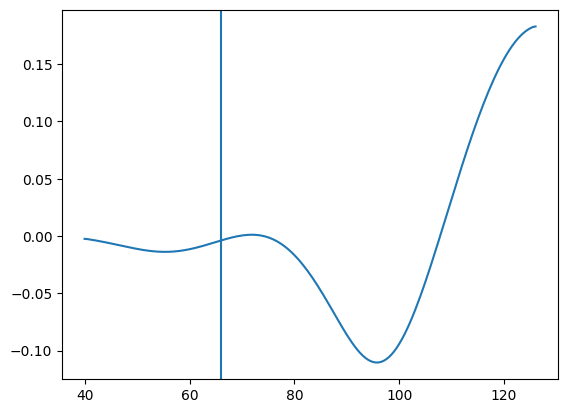

In [80]:
plt.plot(electrodes.z,e_field_z[61,61,:])
plt.axvline(x=66)

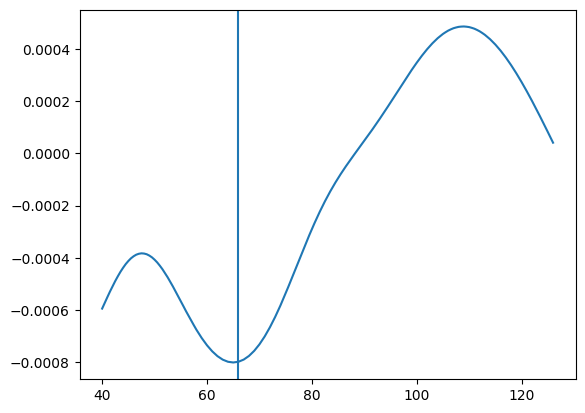

In [81]:
plt.plot(electrodes.z,e_field_along_chosen_line[61,61,:])
plt.axvline(x=66)

<xarray.DataArray 'x' ()>
array(102.5)
Coordinates:
    x        float64 102.5
-0.09127570667288865


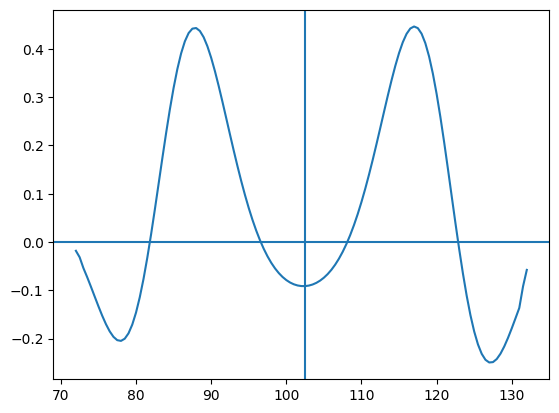

In [416]:
e_x_gradient=np.gradient(e_field_x[:,61,z_coord],0.05)
plt.plot(electrodes.x,e_x_gradient)
plt.axvline(x=102.5)
print(electrodes.x[61])
plt.axhline(y=0)
print(e_x_gradient[61])

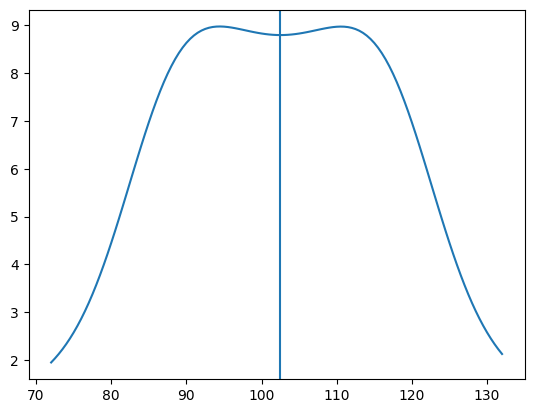

In [417]:
plt.plot(electrodes.x,e_field_z[:,61,51])
plt.axvline(x=102.5)

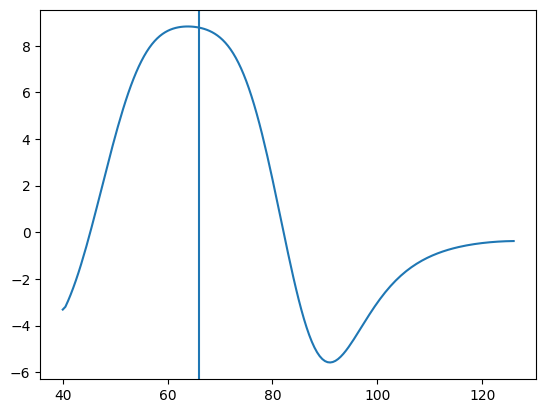

In [418]:
plt.plot(electrodes.z,e_field_z[61,61,:])
plt.axvline(x=66)

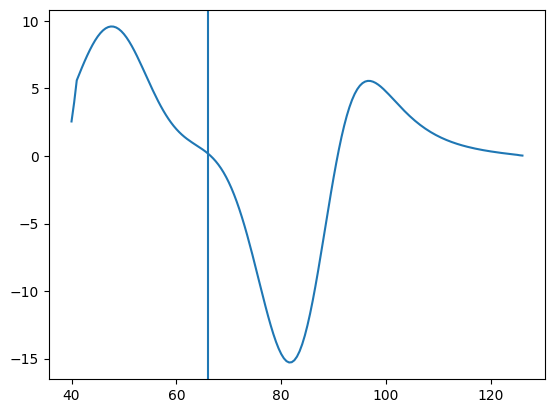

In [331]:
plt.plot(electrodes.z,np.gradient(e_field_z[61,61,:],0.05))
plt.axvline(x=66)

In [339]:
np.gradient(e_field_z[61,61,:],0.05)[51]

0.3443479290556972

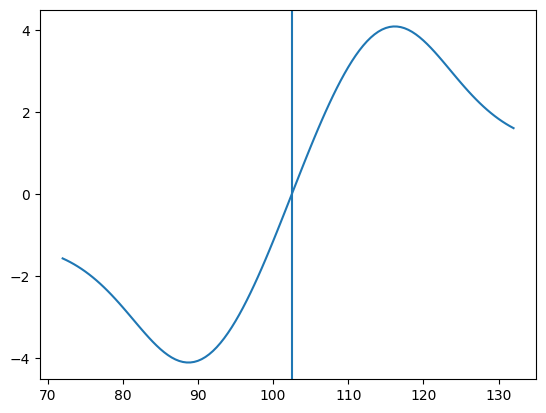

In [16]:
plt.plot(electrodes.y,e_field_x[61,:,z_coord])
plt.axvline(x=102.5)

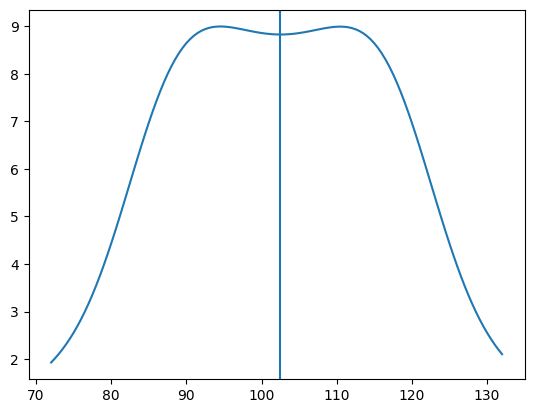

In [278]:
plt.plot(electrodes.x,e_field_z[:,61,z_coord])
plt.axvline(x=102.5)

In [ ]:
e_x_gradient=np.gradient(e_field_x[:,61,z_coord],0.05)
plt.plot(electrodes.x,e_x_gradient)
plt.axvline(x=102.5)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

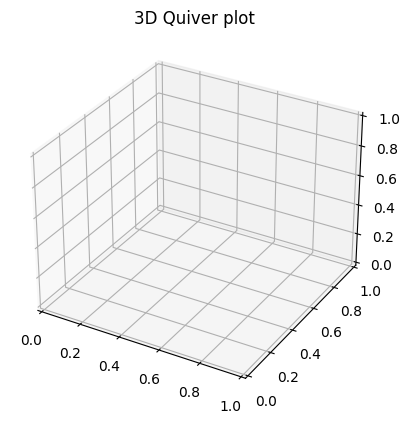

In [214]:
skip=15
import matplotlib.pyplot as plt
import numpy as np

X, Y, Z = np.meshgrid(electrodes.x[::skip],
                      electrodes.y[::skip],
                      electrodes.z[::skip])

#U = np.sin(np.pi * X) * np.cos(np.pi * Y) * np.cos(np.pi * Z)
#V = -np.cos(np.pi * X) * np.sin(np.pi * Y) * np.cos(np.pi * Z)
#W = (np.sqrt(2.0 / 3.0) * np.cos(np.pi * X) * np.cos(np.pi * Y) *
   #  np.sin(np.pi * Z))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("3D Quiver plot")

#drawing quiver plot
ax.quiver(X, Y, Z, e_x[::skip,::skip,::skip], e_y[::skip,::skip,::skip], e_z[::skip,::skip,::skip], length=5, normalize=True)

plt.show()

In [258]:
a_x=electrodes.electrode2.x
a_y=electrodes.electrode2.y
a_z=electrodes.electrode2.z

In [40]:
#np.shape(new_potential[int(width*2-144),int(width*2-144),:])

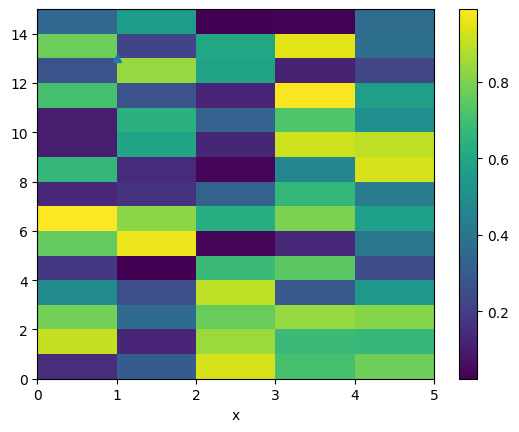

In [351]:
import matplotlib.pyplot as plt
import numpy as np
data = np.random.rand(15,5)
plt.pcolormesh(data, cmap='viridis')
plt.plot(1,13,'^')
plt.xlabel("x")
plt.colorbar()
plt.show()

<xarray.DataArray 'z' ()>
array(40.)
Coordinates:
    z        float64 40.0 <xarray.DataArray 'z' ()>
array(126.)
Coordinates:
    z        float64 126.0
90
100.0
max potential z coord <xarray.DataArray 'y' ()>
array(117.5)
Coordinates:
    y        float64 117.5


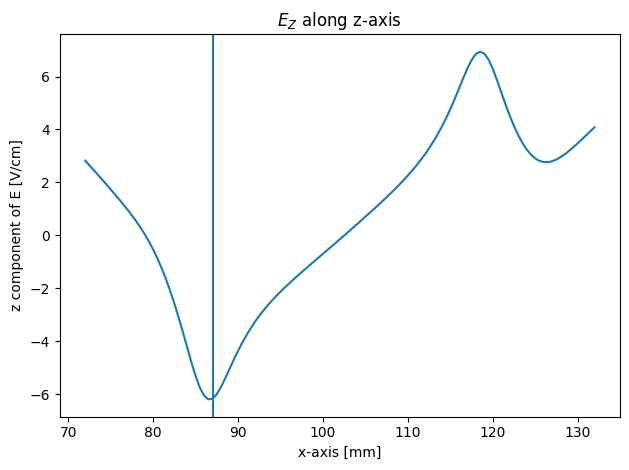

In [35]:
# plot  z component of electric field in x direction

width = 102.5#mm
height = 66#mm
#indexing starts at 144 mm
# range in z direction
start = int(99.5*2-144) #ask
end = int(106.*2-144)

#plt.plot(electrodes.x[:],new_potential[:,int(width*2-144),int(width*2-144)])
#plt.plot(electrodes.y[:],new_potential[2*int(102.5-72),:,0])
plt.plot(electrodes.y[:],new_potential[0,:,0])

print(electrodes.z[0],electrodes.z[-1])
#plt.plot(electrodes.z[start:end:],e_field_x[])
temp=new_potential[:,50,13]
max_potential_index=list(new_potential[:,50,13]).index(max((temp)))


print(max_potential_index)
print(np.max((new_potential[:,50,13])))
print("max potential z coord",electrodes.y[max_potential_index+1])

#print(electrodes.z[z_index])
plt.xlabel("x-axis [mm]")
plt.ylabel("z component of E [V/cm]")
plt.title("$E_Z$ along z-axis")
#plt.ylim(-15,-10)
plt.axvline(x=87)
#plt.axhline(y=0)

# plt.title("E-field in z-direction, plates antisymmetrically charced")
# plt.show()
plt.tight_layout()
#plt.savefig('E_x,field_along_z.png')

168.0
44.14773754138393


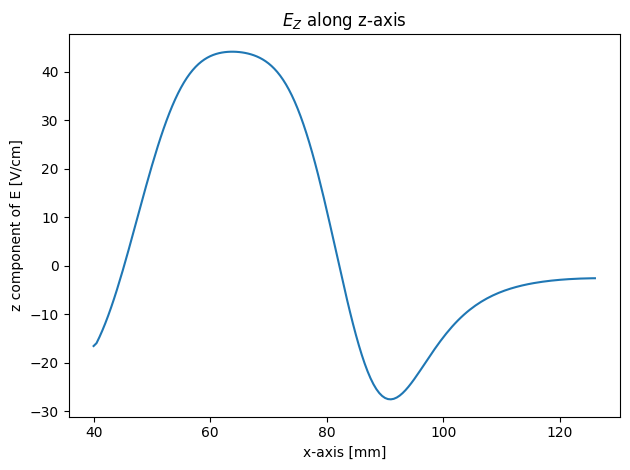

In [16]:
#width = 102.5#mm
#height = 66#mm
#indexing starts at 144 mm
# range in z direction
start = int(99.5*2-144) #ask
end = int(106.*2-144)

plt.plot(electrodes.z[:],e_field_z[int(width*2-144),int(width*2-144),:])
#plt.plot(electrodes.z[start:end:],e_field_x[])
print(np.argmax(abs(e_field_z[int(width*2-144),int(width*2-144),:]))*0.5+144)
print(np.max(abs(e_field_z[int(width*2-144),int(width*2-144),:])))

plt.xlabel("x-axis [mm]")
plt.ylabel("z component of E [V/cm]")
plt.title("$E_Z$ along z-axis")
# plt.title("E-field in z-direction, plates antisymmetrically charced")
# plt.show()
plt.tight_layout()
#plt.savefig('E_x,field_along_z.png')

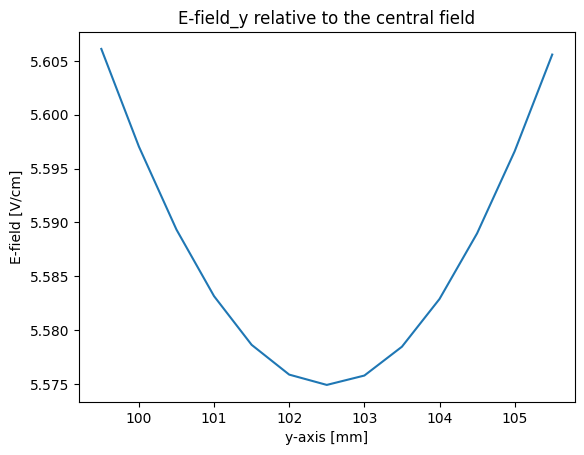

In [80]:
width = 102.5
height = 66
start = int(99.5*2-144)
end = int(106.*2-144)

plt.plot(electrodes.y[start:end:],e_field_z[int(width*2-144),start:end:,int(height*2-80)])
plt.xlabel("y-axis [mm]")
plt.ylabel("E-field [V/cm]")
plt.title("E-field_y relative to the central field")
plt.show()

Text(0, 0.5, '$E_z$ [V/cm]')

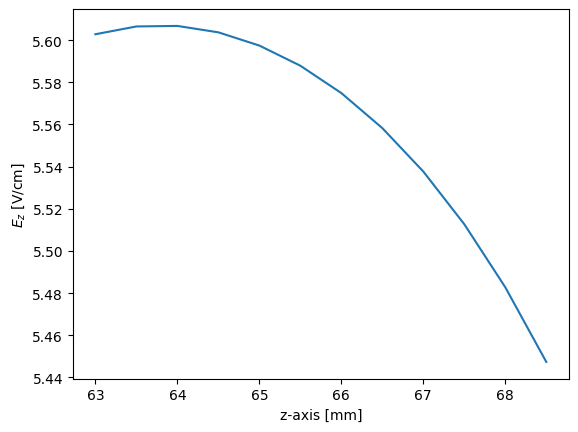

In [40]:
width = 102.5
height = 66
start = int(63.*2-80)
end = int(69*2-80)

plt.plot(electrodes.z[start:end:],e_field_z[int(width*2-144),int(width*2-144),start:end:])
plt.xlabel("z-axis [mm]")
plt.ylabel(r"$E_z$ [V/cm]")
# plt.title("E-field_z relative to the central field")

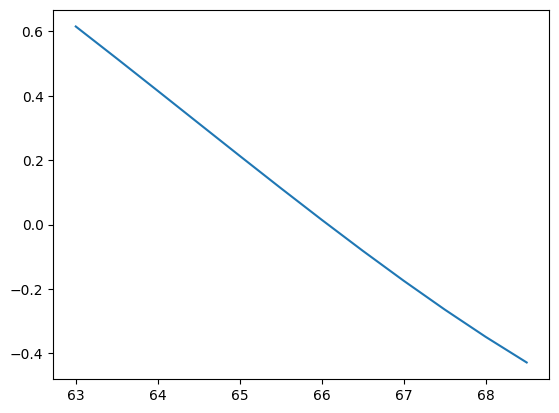

In [41]:
new_potential = 12.7*potential(1,1,1,1,1,1,1,1,0,0,0,0,0) #field z
e_field_z = -1*np.gradient(new_potential, 0.05, axis=2)
plt.plot(electrodes.z[start:end:],e_field_z[int(width*2-144),int(width*2-144),start:end:])

# 4. Get value and gradient for z-field

In [42]:
width = 102.5
height = 66
start = int(65.5*2-80)
end = int(67*2-80)

voltage=[]
gradient=[]
err_gradient=[]
field_z = []
total = []
positions = electrodes.z[start:end:]
for i in range(1,20):
    new_potential = i*potential(1,1,1,1,-1,-1,-1,-1,0,0,0,0,0)
#     e_field_x = -1*np.gradient(new_potential, 0.05, axis=0)
#     e_field_y = -1*np.gradient(new_potential, 0.05, axis=1)
    e_field_z = -1*np.gradient(new_potential, 0.05, axis=2)
#     abs_e_field = np.sqrt(e_field_x**2+e_field_y**2+e_field_z**2)
    electricity_z= e_field_z[int(width*2-144),int(width*2-144),start:end]
    grad_z_field = np.gradient(electricity_z,0.5)[1]
#     popt2,pcov2=curve_fit(linear,positions, electricity_z)
    voltage.append(float(i))
    gradient.append(grad_z_field)
#     err_gradient.append(float(pcov2[0,0])**0.5)
    field_z.append(float(e_field_z[int(width*2-144),int(width*2-144),height]))
#     total.append(float(abs_e_field[int(width*2-144)+1,int(width*2-144),height]))
voltage = np.array(voltage)
# total = np.array(total)
field_z = np.array(field_z)
gradient = np.array(gradient)

C:\Users\REET\miniconda3_new\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


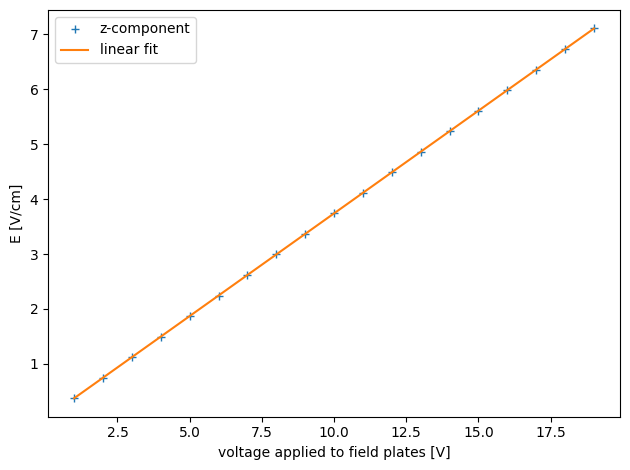

In [43]:
# plt.plot(voltage,total, label='total field')
plt.plot(voltage,field_z,'+', label ='z-component')
plt.xlabel('voltage applied to field plates [V]')
plt.ylabel('E [V/cm]')
# plt.title('Electric field at the center, plates antisymmetrically charged')
popt,pcov = curve_fit(linear, voltage, field_z)
rate_field_z = popt[0]
err_rate_field_z = pcov[0,0]**0.5
plt.plot(voltage, linear(voltage,*popt), label = 'linear fit')
plt.legend()
plt.tight_layout()
plt.savefig('field_antisymmetric.png')

In [36]:
print("The electric field in the middle changes with "+str(round(rate_field_z,12))+"+/-"+str(round(err_rate_field_z,12))+" (V/cm)/V")

The electric field in the middle changes with 0.374049617729+/-inf (V/cm)/V


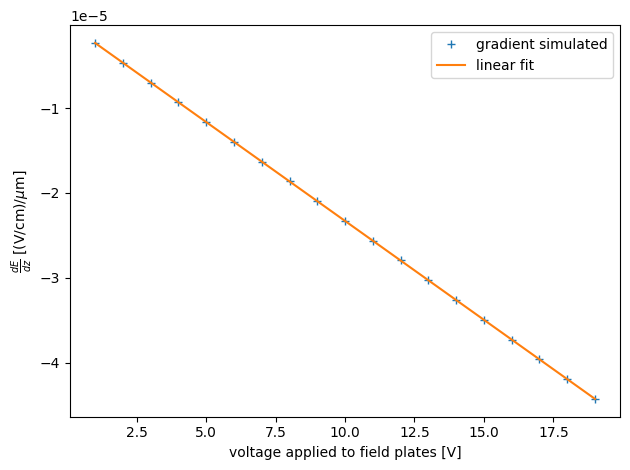

In [37]:
plt.plot(voltage, gradient/1000,'+', label = 'gradient simulated')
plt.xlabel('voltage applied to field plates [V]')
plt.ylabel(r'$\frac{dE}{dz}$ [(V/cm)/$\mu$m]')
# plt.title('Electric field gradient at the center, plates antisymmetrically charged')
popt1,pcov1 = curve_fit(linear, voltage, gradient/1000)
rate_gradient_z = popt1[0]
err_rate_gradient_z = pcov1[0,0]**0.5
plt.plot(voltage, linear(voltage,*popt1), label = 'linear fit')
plt.legend()
plt.tight_layout()
plt.savefig('grad_antisymmetric.png')

In [38]:
print(r"The electric field in the middle changes with "+str(round(rate_gradient_z,15))+"+/-"+str(round(err_rate_gradient_z,15
                                                                                                     ))+" (V/cm/$\mu$m)/V")

The electric field in the middle changes with -2.330449123e-06+/-0.0 (V/cm/$\mu$m)/V


In [39]:
# plt.plot(voltage, err_gradient/gradient)
# plt.xlabel('voltage applied to field plates [V]')
# plt.ylabel('relative error on the linear fit coefficient')
# plt.tight_layout()
# plt.savefig('gradient_confidence_z.png')
# plt.show()

In [40]:
savematrix = [voltage, field_z,gradient/1000]
np.savetxt("z-data.txt",np.transpose(savematrix))

In [41]:
# voltage,field_z,gradient_test = np.loadtxt("z-data.txt",usecols=[0,1,2], unpack=True)
# print(gradient_test)

# 5. Get value and gradient for gradient field

In [42]:
width = 102.5
height = 66
start = int(65.5*2-80)
end = int(67*2-80)

voltage_g=[]
gradient_g=[]
err_gradient_g=[]
field_z_g = []
total_g = []
positions = electrodes.z[start:end:]
for i in range(1,30):
    new_potential = -i*potential(1,1,1,1,1,1,1,1,0,0,0,0,0)
#     e_field_x = -1*np.gradient(new_potential, 0.05, axis=0)
#     e_field_y = -1*np.gradient(new_potential, 0.05, axis=1)
    e_field_z = -1*np.gradient(new_potential, 0.05, axis=2)
#     abs_e_field = np.sqrt(e_field_x**2+e_field_y**2+e_field_z**2)
    electricity_z= e_field_z[int(width*2-144),int(width*2-144),start:end]
    grad_g_field = np.gradient(electricity_z,0.5)[1]
#     popt2,pcov2=curve_fit(linear,positions, electricity_z)
    voltage_g.append(float(i))
    
    gradient_g.append(grad_g_field)
#     err_gradient_g.append(float(pcov2[0,0])**0.5)
    field_z_g.append(float(e_field_z[int(width*2-144),int(width*2-144),height]))
#     total_g.append(float(abs_e_field[int(width*2-144),int(width*2-144),height]))
voltage_g = np.array(voltage_g)
total_g = np.array(total_g)
field_z_g = np.array(field_z_g)
gradient_g = np.array(gradient_g)
# err_gradient_g = np.array(err_gradient_g)

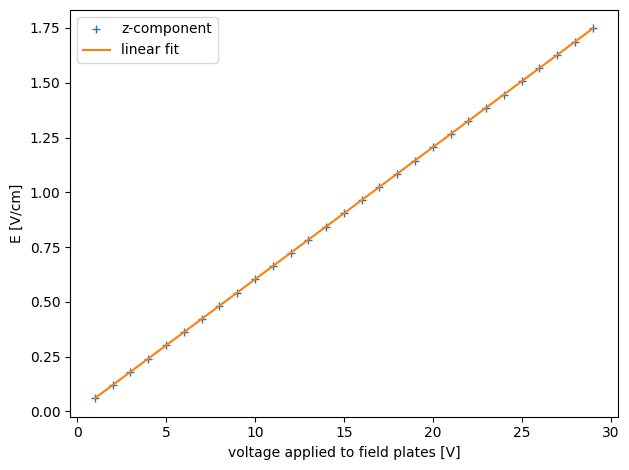

In [43]:
# plt.plot(voltage_g[:maxvolt],total_g[:maxvolt], label='total field')
plt.plot(voltage_g,field_z_g,'+', label ='z-component')
plt.xlabel('voltage applied to field plates [V]')
plt.ylabel('E [V/cm]')
# plt.title('Electric field at the center')
popt2,pcov2 = curve_fit(linear, voltage_g, field_z_g)
rate_field_g = popt2[0]
err_rate_field_g = pcov2[0,0]**0.5
plt.plot(voltage_g, linear(voltage_g,*popt2), label = 'linear fit')
plt.legend()
# plt.show()
plt.tight_layout()
plt.savefig('field_symmetric.png')

In [44]:
print("The electric field in the middle changes with "+str(round(rate_field_g,16))+"+/-"+str(round(err_rate_field_g,16))+" (V/cm)/V")

The electric field in the middle changes with 0.0602637574775808+/-inf (V/cm)/V


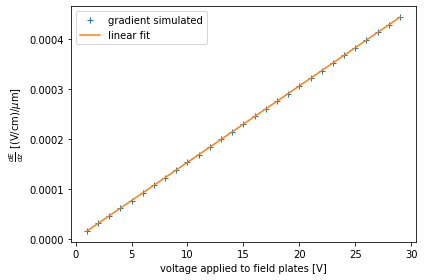

In [45]:
plt.plot(voltage_g, gradient_g/1000,'+', label = 'gradient simulated')
plt.xlabel('voltage applied to field plates [V]')
plt.ylabel(r'$\frac{dE}{dz}$ [(V/cm)/$\mu$m]')
# plt.title('Electric field gradient at the center')
popt3,pcov3 = curve_fit(linear, voltage_g, gradient_g/1000)
rate_gradient_g = popt3[0]
err_rate_gradient_g = pcov3[0,0]**0.5
plt.plot(voltage_g, linear(voltage_g,*popt3), label = 'linear fit')
plt.legend()
plt.tight_layout()
plt.savefig('grad_symmetric')

In [46]:
print("The electric field in the middle changes with "+str(round(rate_gradient_g,12))+"+/-"+str(round(err_rate_gradient_g,12))+" (V/cm/mum)/V")

The electric field in the middle changes with 1.5318868e-05+/-inf (V/cm/mum)/V


In [47]:
savematrix = [voltage_g, field_z_g,gradient_g/1000]
np.savetxt("grad-data.txt",np.transpose(savematrix))

# 6. Getting voltages for required field

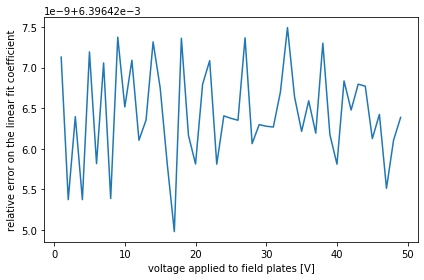

In [72]:
plt.plot(voltage_g, err_gradient_g/gradient_g)
plt.xlabel('voltage applied to field plates [V]')
plt.ylabel('relative error on the linear fit coefficient')
plt.tight_layout()
plt.savefig('gradient_confidence.png')
plt.show()

In [73]:
gradient_mic=gradient_g/1000
maximal_gradient=gradient_mic[-1]
print(maximal_gradient)
# cloud_size=600
# maximal_range=cloud_size*maximal_gradient
# print("The maximal accessible range is "+str(round(maximal_range,3))+" V/cm")

0.0007600590593883498


In [74]:
def electric_from_voltage(Vz,Vg):
    E0= Vz*rate_field_z+Vg*rate_field_g
    gradE = Vz*rate_gradient_z+Vg*rate_gradient_g
    return E0, gradE

In [75]:
print(electric_from_voltage(9.122018,30))

(5.2200000704421985, 0.0004440838826422161)


In [76]:
def voltage_from_electronic(E0,gradE):
    detA = rate_field_z*rate_gradient_g-rate_field_g*rate_gradient_z
    Vz = 1/detA*(rate_gradient_g*E0-rate_field_g*gradE)
    Vg = 1/detA*(-rate_gradient_z*E0+rate_field_z*gradE)
    return Vz,Vg

In [77]:
V0, Vg = voltage_from_electronic(5.57,0.0006)
print(V0-Vg)
print(-Vg-V0)

-31.49697227191285
-48.405841816653194


In [78]:
V0, Vg = voltage_from_electronic(5.57,0)
print(V0-Vg)
print(-Vg-V0)

12.354769179418794
-16.723519326155845


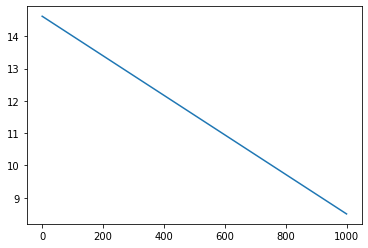

In [79]:
Uu = np.linspace(12.918047746170963,-31.16942880247399,1000)
Ud = np.linspace(-16.31655776401097,-48.169195848112395,1000)
U0 = (Uu-Ud)/2
Ug = -(Uu+Ud)/2
time = np.linspace(0,999,1000)
plt.plot(time,U0)

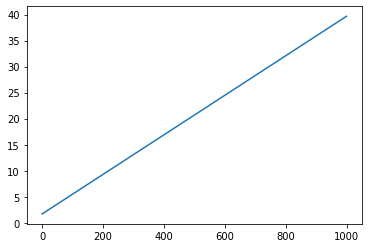

In [80]:
plt.plot(time,Ug)

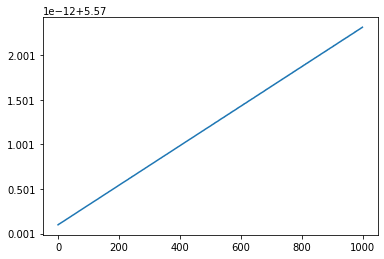

In [81]:
E, gradE = electric_from_voltage(U0,Ug)
plt.plot(time,E)

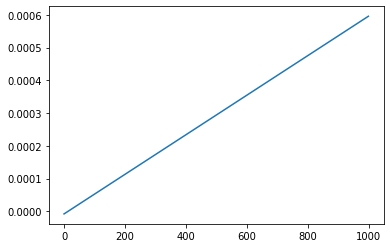

In [82]:
plt.plot(time,gradE)